In [ ]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd
import torch
from torch import nn
import sys
import numpy as np
from sklearn import metrics
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from matplotlib import pyplot as plt


#for working in Google Colab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
sys.path.append('/content/drive/MyDrive/ECG_project/')

import data_preprocessing
import ECG

Mounted at /content/drive


In [ ]:
!pip install biosppy
!pip install pytorch-lightning

In [ ]:
swell_data = data_preprocessing.load_data('/content/drive/MyDrive/swell_dict_index_6.npy') 
swell_data = data_preprocessing.swell_prepare_for_10fold(swell_data)
#fix the range of the labels to init from value of zero
swell_data[:,1:4]-=1

splits=np.load("/content/drive/MyDrive/ECG_project/splits_A.npy",allow_pickle=True)
x_tr=[]
y_tr=[]
for i in splits[0]:
    x_tr.append(swell_data[i,4:])
    y_tr.append(swell_data[i,:4])
x_train=np.array(x_tr)
y_train=np.array(y_tr)

x_te=[]
y_te=[]
for i in splits[1]:
    x_te.append(swell_data[i,4:])
    y_te.append(swell_data[i,:4])
x_test=np.array(x_te)
y_test=np.array(y_te)

x_train = torch.from_numpy(x_train).float().unsqueeze(1)
y_train = torch.tensor(y_train).long()
x_test = torch.from_numpy(x_test).float().unsqueeze(1)
y_test = torch.tensor(y_test).long()
tensor_dataset = torch.utils.data.TensorDataset(x_train, y_train)
tensor_dataset_test = torch.utils.data.TensorDataset(x_test, y_test)


train_loader = DataLoader(tensor_dataset, batch_size=128)
test_loader = DataLoader(tensor_dataset_test,batch_size=128) 

In [ ]:
#same x to all labels
x=train_loader.dataset.tensors[0].numpy()
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x[:,0,:]) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13135 samples in 0.020s...
[t-SNE] Computed neighbors for 13135 samples in 36.429s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13135
[t-SNE] Computed conditional probabilities for sample 2000 / 13135
[t-SNE] Computed conditional probabilities for sample 3000 / 13135
[t-SNE] Computed conditional probabilities for sample 4000 / 13135
[t-SNE] Computed conditional probabilities for sample 5000 / 13135
[t-SNE] Computed conditional probabilities for sample 6000 / 13135
[t-SNE] Computed conditional probabilities for sample 7000 / 13135
[t-SNE] Computed conditional probabilities for sample 8000 / 13135
[t-SNE] Computed conditional probabilities for sample 9000 / 13135
[t-SNE] Computed conditional probabilities for sample 10000 / 13135
[t-SNE] Computed conditional probabilities for sample 11000 / 13135
[t-SNE] Computed conditional probabilities for sample 12000 / 13135
[t-SNE] Computed conditional probabilities for sa

[Text(0.5, 1.0, 'Stress data T-SNE projection')]

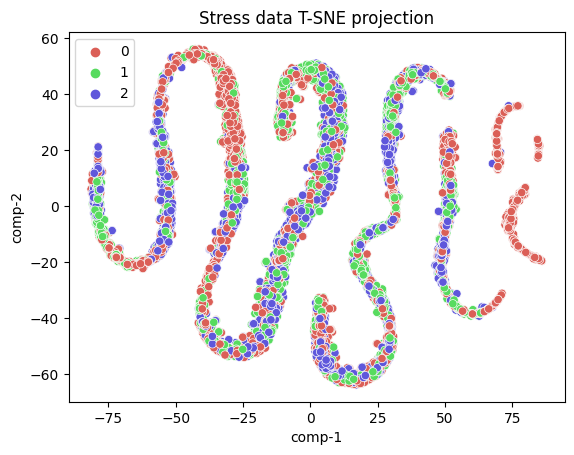

In [ ]:
# Stress TSNE
y=train_loader.dataset.tensors[1][:,1].numpy()
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Stress data T-SNE projection") 

[Text(0.5, 1.0, 'Arousal data T-SNE projection')]

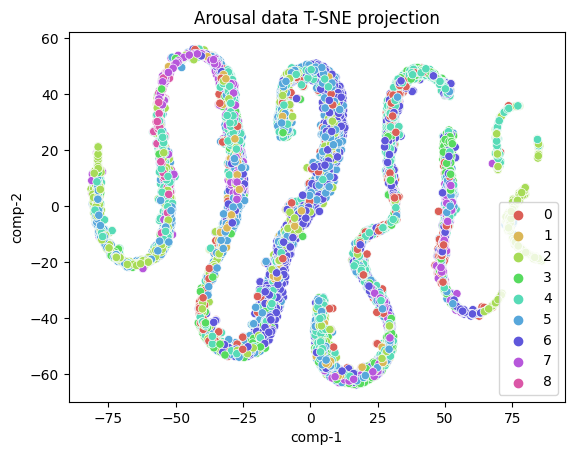

In [ ]:
# Arousal TSNE
y=train_loader.dataset.tensors[1][:,2].numpy()
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 9),
                data=df).set(title="Arousal data T-SNE projection") 

[Text(0.5, 1.0, 'Valence data T-SNE projection')]

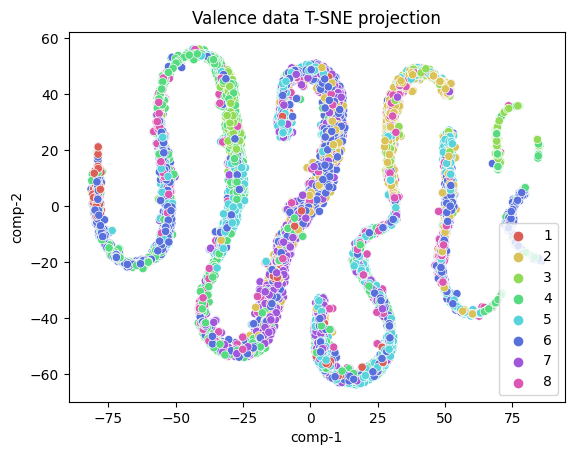

In [ ]:
# Valence TSNE
y=train_loader.dataset.tensors[1][:,3].numpy()
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 8),
                data=df).set(title="Valence data T-SNE projection") 

In [ ]:
# calc prediction

model_recovered=ECG.EmotionRec()
model_recovered.load_state_dict(torch.load("/content/drive/MyDrive/ECG_project/model_light_250.pt"))
model_recovered.eval()
trainer = pl.Trainer()
y_hat=trainer.predict(model_recovered,test_loader)

# split y_hat (the prediction of the model) to y_hat of each classifier
y_hat_stress=[]
y_hat_arousal=[]
y_hat_valence=[]
for i in range(len(y_hat)):
  y_hat_stress.append(y_hat[i][0])
  y_hat_arousal.append(y_hat[i][1])
  y_hat_valence.append(y_hat[i][2])

y_hat_stress=np.concatenate(y_hat_stress, axis=0)
y_hat_arousal=np.concatenate(y_hat_arousal, axis=0)
y_hat_valence=np.concatenate(y_hat_valence, axis=0)

    # split y (the true labels) to y of each classifier
y_stress=test_loader.dataset.tensors[1][:,1].numpy()
y_arousal=test_loader.dataset.tensors[1][:,2].numpy()
y_valence=test_loader.dataset.tensors[1][:,3].numpy()
samples=test_loader.dataset.tensors[0].numpy()
pp=test_loader.dataset.tensors[1][:,0].numpy()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


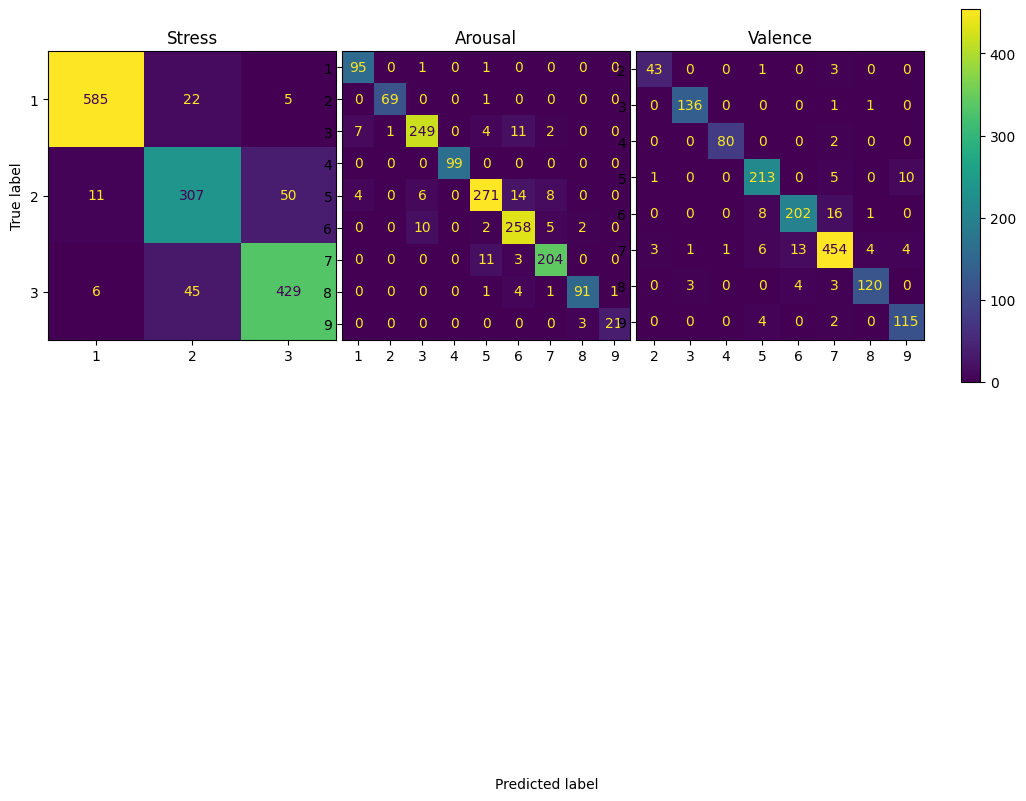

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,15))

confusion_matrix_stress = metrics.confusion_matrix(y_stress, y_hat_stress)
display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_stress, display_labels = [1,2,3])
display.plot(ax=ax[0])
display.ax_.set_title("Stress")
display.im_.colorbar.remove()
display.ax_.set_xlabel('')

confusion_matrix_arousal = metrics.confusion_matrix(y_arousal, y_hat_arousal)
display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_arousal, display_labels = [1,2,3,4,5,6,7,8,9])
display.plot(ax=ax[1])
display.ax_.set_title("Arousal")
display.im_.colorbar.remove()
display.ax_.set_xlabel('')
display.ax_.set_ylabel('')

confusion_matrix_valence = metrics.confusion_matrix(y_valence, y_hat_valence)
display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_valence, display_labels = [2,3,4,5,6,7,8,9])
display.plot(ax=ax[2])
display.ax_.set_title("Valence")
display.im_.colorbar.remove()
display.ax_.set_xlabel('')
display.ax_.set_ylabel('')

fig.tight_layout()
fig.text(0.5, 0.36, 'Predicted label', ha='left')
fig.subplots_adjust(top=1.5)
#fig.suptitle("Epoch 50")
fig.subplots_adjust(wspace=0.02, hspace=0.01)
fig.colorbar(display.im_, ax=ax,fraction=0.02, pad=0.04)
fig.show()

In [ ]:
# for unite:
class EmotionRec_3(ECG.EmotionRec):
  def __init__(self):
    super().__init__()
    self.arousal = nn.Sequential(nn.Flatten(),
                                nn.Linear(128, 512),
                                nn.ReLU(),
                                nn.Linear(512, 512),
                                nn.ReLU(),
                                nn.Linear(512,3)
                                )
                  
    self.valence = nn.Sequential(nn.Flatten(),
                                nn.Linear(128, 512),
                                nn.ReLU(),
                                nn.Linear(512, 512),
                                nn.ReLU(),
                                nn.Linear(512,3)
                                )
#unite the labels   
for i in range(len(test_loader.dataset.tensors[1][:,2].numpy())):
    if(test_loader.dataset.tensors[1][i,2]<3):
        test_loader.dataset.tensors[1][i,2]=0

    elif(test_loader.dataset.tensors[1][i,2]>5):
        test_loader.dataset.tensors[1][i,2]=2

    else:
        test_loader.dataset.tensors[1][i,2]=1


for i in range(len(test_loader.dataset.tensors[1][:,3].numpy())):
    if(test_loader.dataset.tensors[1][i,3]<3):
        test_loader.dataset.tensors[1][i,3]=0
        
    elif(test_loader.dataset.tensors[1][i,3]>5):
        test_loader.dataset.tensors[1][i,3]=2

    else:
        test_loader.dataset.tensors[1][i,3]=1


for i in range(len(train_loader.dataset.tensors[1][:,2].numpy())):
    if(train_loader.dataset.tensors[1][i,2]<3):
        train_loader.dataset.tensors[1][i,2]=0

    elif(train_loader.dataset.tensors[1][i,2]>5):
        train_loader.dataset.tensors[1][i,2]=2

    else:
        train_loader.dataset.tensors[1][i,2]=1


for i in range(len(train_loader.dataset.tensors[1][:,3].numpy())):
    if(train_loader.dataset.tensors[1][i,3]<3):
        train_loader.dataset.tensors[1][i,3]=0
        
    elif(train_loader.dataset.tensors[1][i,3]>5):
        train_loader.dataset.tensors[1][i,3]=2

    else:
        train_loader.dataset.tensors[1][i,3]=1

<ipython-input-14-c1795a897aa0>:8: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'Arousal data T-SNE projection')]

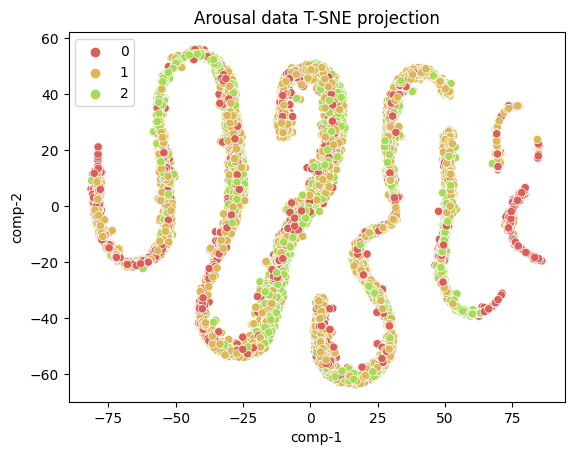

In [ ]:
# Arousal TSNE - for unite
y=train_loader.dataset.tensors[1][:,2].numpy()
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 9),
                data=df).set(title="Arousal data T-SNE projection") 

<ipython-input-15-d2e705471da9>:8: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'Valence data T-SNE projection')]

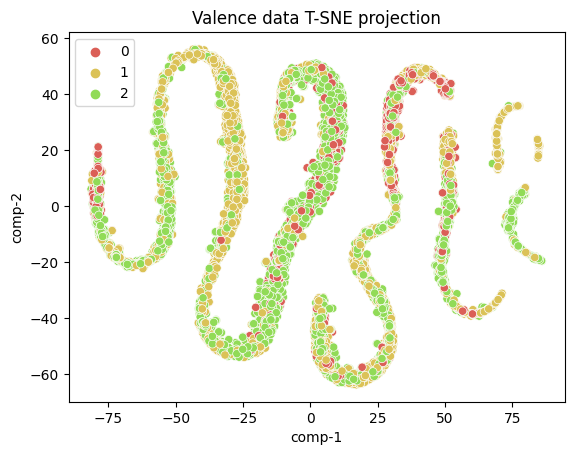

In [ ]:
# Valence TSNE for unite
y=train_loader.dataset.tensors[1][:,3].numpy()
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 8),
                data=df).set(title="Valence data T-SNE projection") 

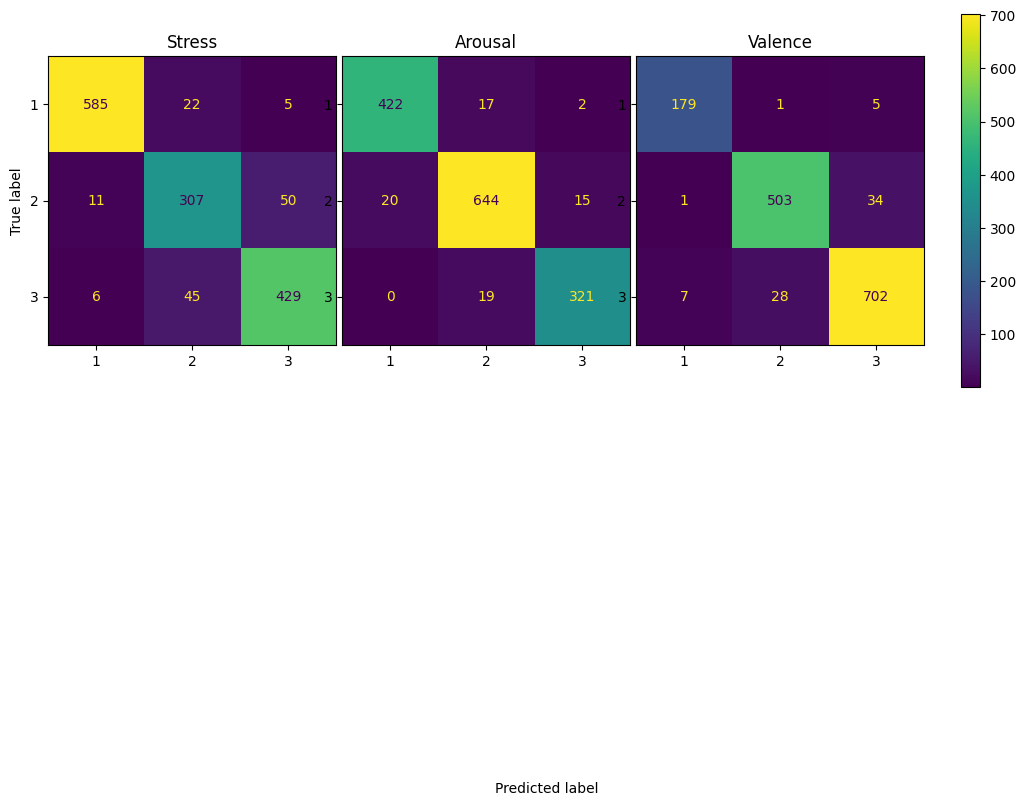

In [ ]:
#unite y_hat   
for i in range(len(y_hat_arousal)):
    if(y_hat_arousal[i]<3):
      y_hat_arousal[i]=0
    elif(y_hat_arousal[i]>5):
      y_hat_arousal[i]=2
    else:
      y_hat_arousal[i]=1

for i in range(len(y_hat_valence)):
    if(y_hat_valence[i]<3):
      y_hat_valence[i]=0
    elif(y_hat_valence[i]>5):
      y_hat_valence[i]=2
    else:
      y_hat_valence[i]=1




# unite labels after training 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,15))

confusion_matrix_stress = metrics.confusion_matrix(y_stress, y_hat_stress)
display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_stress, display_labels = [1,2,3])
display.plot(ax=ax[0])
display.ax_.set_title("Stress")
display.im_.colorbar.remove()
display.ax_.set_xlabel('')

confusion_matrix_arousal = metrics.confusion_matrix(y_arousal, y_hat_arousal)
display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_arousal, display_labels =[1,2,3])
display.plot(ax=ax[1])
display.ax_.set_title("Arousal")
display.im_.colorbar.remove()
display.ax_.set_xlabel('')
display.ax_.set_ylabel('')

confusion_matrix_valence = metrics.confusion_matrix(y_valence, y_hat_valence)
display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_valence, display_labels =[1,2,3])
display.plot(ax=ax[2])
display.ax_.set_title("Valence")
display.im_.colorbar.remove()
display.ax_.set_xlabel('')
display.ax_.set_ylabel('')

fig.tight_layout()
fig.text(0.5, 0.36, 'Predicted label', ha='left')
fig.subplots_adjust(top=1.5)
#fig.suptitle("Epoch 50")
fig.subplots_adjust(wspace=0.02, hspace=0.01)
fig.colorbar(display.im_, ax=ax,fraction=0.02, pad=0.04)
fig.show()

In [ ]:
# calc prediction

model_recovered=EmotionRec_3()
model_recovered.load_state_dict(torch.load("/content/drive/MyDrive/ECG_project/model_3_labels_split_A.pt"))
model_recovered.eval()
trainer = pl.Trainer()
y_hat=trainer.predict(model_recovered,test_loader)

# split y_hat (the prediction of the model) to y_hat of each classifier
y_hat_stress=[]
y_hat_arousal=[]
y_hat_valence=[]
for i in range(len(y_hat)):
  y_hat_stress.append(y_hat[i][0])
  y_hat_arousal.append(y_hat[i][1])
  y_hat_valence.append(y_hat[i][2])

y_hat_stress=np.concatenate(y_hat_stress, axis=0)
y_hat_arousal=np.concatenate(y_hat_arousal, axis=0)
y_hat_valence=np.concatenate(y_hat_valence, axis=0)

    # split y (the true labels) to y of each classifier
y_stress=test_loader.dataset.tensors[1][:,1].numpy()
y_arousal=test_loader.dataset.tensors[1][:,2].numpy()
y_valence=test_loader.dataset.tensors[1][:,3].numpy()
samples=test_loader.dataset.tensors[0].numpy()
pp=test_loader.dataset.tensors[1][:,0].numpy()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

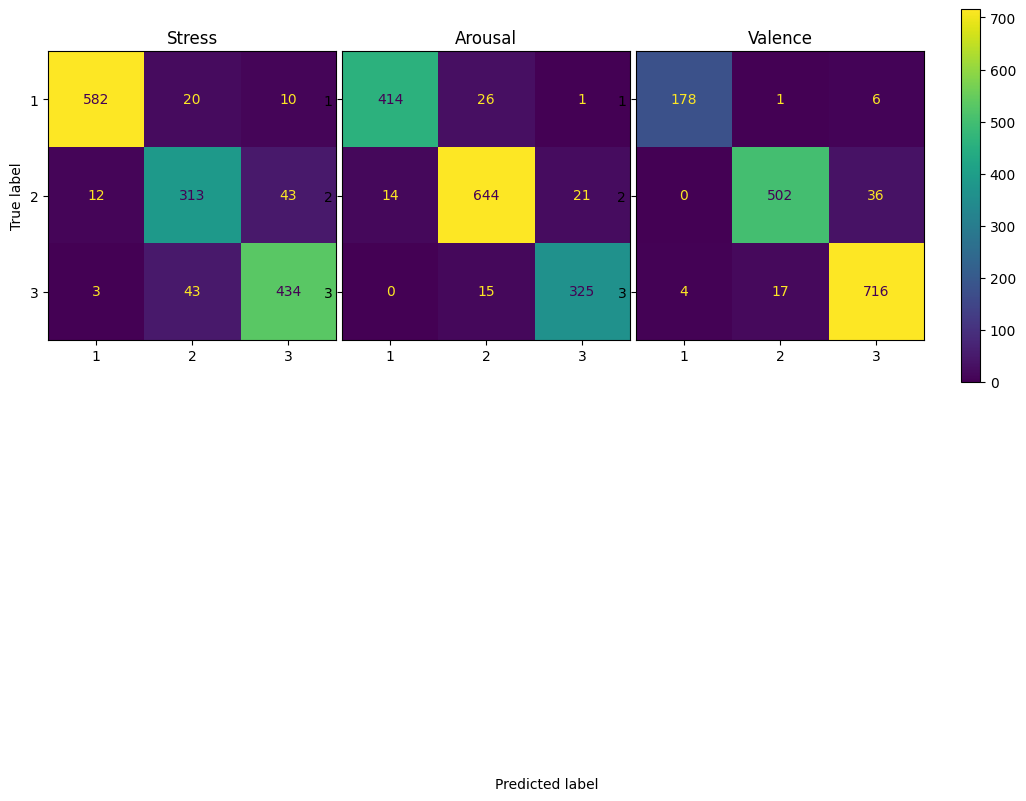

In [ ]:
#unite before training

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,15))

confusion_matrix_stress = metrics.confusion_matrix(y_stress, y_hat_stress)
display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_stress, display_labels = [1,2,3])
display.plot(ax=ax[0])
display.ax_.set_title("Stress")
display.im_.colorbar.remove()
display.ax_.set_xlabel('')

confusion_matrix_arousal = metrics.confusion_matrix(y_arousal, y_hat_arousal)
display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_arousal, display_labels =[1,2,3])
display.plot(ax=ax[1])
display.ax_.set_title("Arousal")
display.im_.colorbar.remove()
display.ax_.set_xlabel('')
display.ax_.set_ylabel('')

confusion_matrix_valence = metrics.confusion_matrix(y_valence, y_hat_valence)
display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_valence, display_labels =[1,2,3])
display.plot(ax=ax[2])
display.ax_.set_title("Valence")
display.im_.colorbar.remove()
display.ax_.set_xlabel('')
display.ax_.set_ylabel('')

fig.tight_layout()
fig.text(0.5, 0.36, 'Predicted label', ha='left')
fig.subplots_adjust(top=1.5)
#fig.suptitle("Epoch 50")
fig.subplots_adjust(wspace=0.02, hspace=0.01)
fig.colorbar(display.im_, ax=ax,fraction=0.02, pad=0.04)
fig.show()